In [2]:
import quantstats as qs
import yfinance as yf
import ccxt as ccxt
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.ticker import (
    FormatStrFormatter as _FormatStrFormatter,
    FuncFormatter as _FuncFormatter
)

#my imports
import sys
sys.path.insert(1, '../scripts')
import utils as utl
import html_evaluation_portfolio as hep
import volatility_estimator as ve

## Comparing different all weather portfolios

In [3]:
dictionary = {'x1 leverage' : ['VTI', 'VGLT',  'IAU'],
              'x2 leverage' : ['SSO', 'UBT', 'UGL'],
              'x3 leverage' : ['UPRO', 'TMF', 'IAU']}

dictionary_util =  {'Utilities instead commodities' : ['VTI', 'VGLT', 'VGIT', 'VPU', 'IAU'], 
                    'Utilities instead commodities x3 leverage' : ['UPRO', 'TMF', 'TYD', 'UTSL'],
                    'Utilities instead commodities x2 leverage' : ['SSO', 'UBT', 'UST', 'UPW', 'UGL']}

dictionary_TRP = {'True risk parity' : ['VGLT', 'VTI', 'VGIT', 'VPU', 'IAU'],
                  'True risk parity x3 leverage' : ['TMF', 'UPRO', 'TYD', 'UTSL','UGL' ]}



In [21]:
list_securities_2008 = ['SPY', 'TLT', 'GLD']

In [4]:
from datetime import date
end_date = date.today() - pd.DateOffset(days=180)
start_date = pd.to_datetime(end_date) - pd.DateOffset(days=1824) 
estimator = 'parkinson'
window = 30

In [9]:
dict_df = {}
for name in dictionary:
    list_securities = dictionary[name]
    print(list_securities)
    data = hep.create_dataframe(list_securities) #I can import this dataframe but it is preatty fast.
    
    #mistake in the data
    if 'IAU' in data.columns:
        data['IAU'] = data['IAU'].replace([data['IAU'].max()], 34.599998)
    
    if estimator == 'stdv':
        unique_name = 'stdv'
        for i in list_securities:
            unique_name += '_' + i
            
        df_strd_dev = ve.dataframe_strd_dev(data, 30)
        df_strd_dev = ve.index_df(df_strd_dev, data, window)
        data_perc = hep.return_df(data)
        inv_volat_data = hep.df_inverse_volatility(data_perc, window)
        df_weighted = hep.df_wheighted(inv_volat_data)
        
    if estimator == 'parkinson':
        unique_name = 'parkinson'
        for i in list_securities:
            unique_name += '_' + i
    
        data_h_l = ve.create_dataframe_high_low(list_securities)   
        data_h_l = data_h_l[-1834:]
        df_volat = ve.compute_park_volatility(data_h_l, list_securities, window)
        data.dropna(inplace = True)
        data = data[-1834:]
        df_volat = ve.index_df(df_volat, data, window)
        df_inv_volat = df_volat.applymap(lambda x: 1/x)
        df_weighted = hep.df_wheighted(df_inv_volat)
    
    if estimator == 'satchell':
        unique_name = 'satchell'
        for i in list_securities:
            unique_name += '_' + i
            
        data_ohlc = ve.create_dataframe_ohlc(list_securities)
        data_ohlc = data_ohlc[-1834:]
        df_satchell_volat = ve.compute_satchell_volatility(data_ohlc, list_securities, window)
        data.dropna(inplace = True)
        data = data[-1834:]
        df_satchell_volat = ve.index_df(df_satchell_volat, data, window)
        df_inv_satchell_volat = df_satchell_volat.applymap(lambda x: 1/x)

        df_weighted = hep.df_wheighted(df_inv_satchell_volat)
        display(df_weighted)
        
    data_r = data.div(data.shift(1))-1
    
    #multiply x3 IAU for x3 leverage
    if name == 'x3 leverage':
        data_r['IAU'] = 3*data_r['IAU']
    data_earnings = hep.df_earnings(df_weighted, data_r)
    data_earnings.dropna(inplace = True)
    
    #data_earnings = data_earnings[-1834:] 
    data_earnings = data_earnings[start_date: end_date]
    dict_df[name] = data_earnings

['VTI', 'VGLT', 'IAU']
['SSO', 'UBT', 'UGL']
['UPRO', 'TMF', 'IAU']


          VGLT       UBT       TMF
VGLT  1.000000  0.979874  0.974553
UBT   0.979874  1.000000  0.953672
TMF   0.974553  0.953672  1.000000


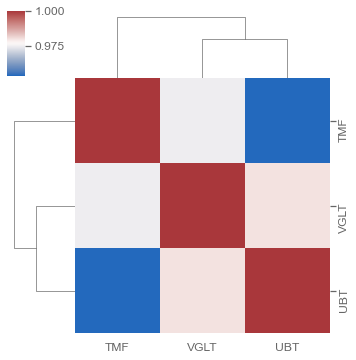

In [6]:
df_leverage_bonds = pd.DataFrame()
df_leverage_bonds['VGLT'] = dict_df['x1 leverage']['VGLT']
df_leverage_bonds['UBT'] = dict_df['x2 leverage']['UBT']
df_leverage_bonds['TMF'] = dict_df['x3 leverage']['TMF']
corr = df_leverage_bonds.corr()
print(corr)
sns.clustermap(corr, figsize=(5,5), cmap='vlag')

           VTI       SSO      UPRO
VTI   1.000000  0.992668  0.981565
SSO   0.992668  1.000000  0.987525
UPRO  0.981565  0.987525  1.000000


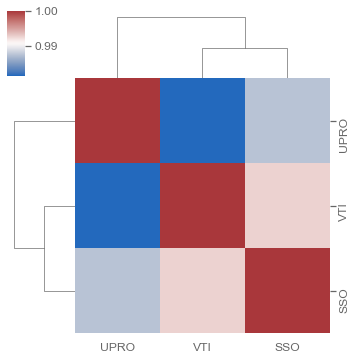

In [8]:
df_leverage_equities = pd.DataFrame()
df_leverage_equities['VTI'] = dict_df['x1 leverage']['VTI']
df_leverage_equities['SSO'] = dict_df['x2 leverage']['SSO']
df_leverage_equities['UPRO'] = dict_df['x3 leverage']['UPRO']
corr = df_leverage_equities.corr()
print(corr)
sns.clustermap(corr, figsize=(5,5), cmap='vlag')

          IAU       UGL       TYD
IAU  1.000000  0.958784  0.286616
UGL  0.958784  1.000000  0.281595
TYD  0.286616  0.281595  1.000000


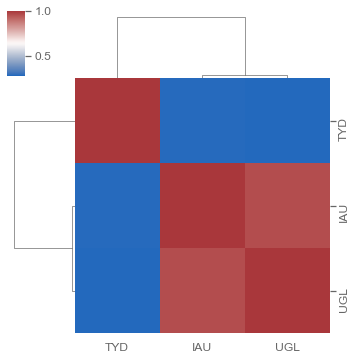

In [9]:
df_leverage_gold = pd.DataFrame()
df_leverage_gold['IAU'] = dict_df['x1 leverage']['IAU']
df_leverage_gold['UGL'] = dict_df['x2 leverage']['UGL']
df_leverage_gold['TYD'] = dict_df['x3 leverage']['TYD']
corr = df_leverage_gold.corr()
print(corr)
sns.clustermap(corr, figsize=(5,5), cmap='vlag')

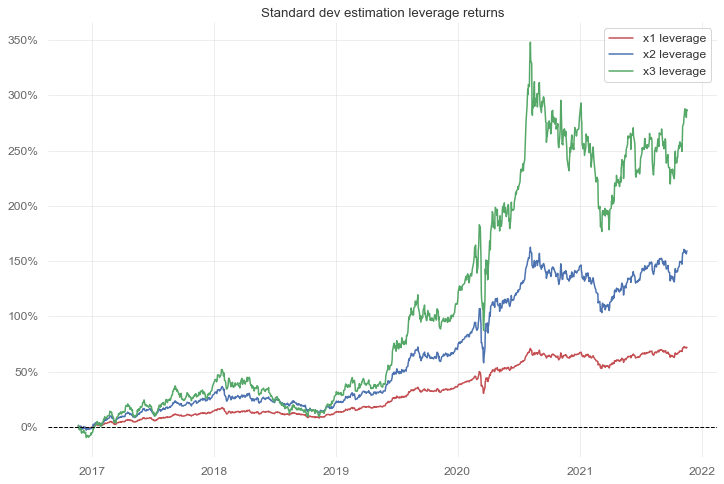

In [11]:
from quantstats.stats import compsum
from quantstats._plotting.core import format_pct_axis

#returns = dict_df['x1 leverage']['Tot']
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Standard dev estimation leverage returns')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(compsum(dict_df['x1 leverage']['Tot']), lw=1.5, label='x1 leverage', color='r', alpha=1)
ax.plot(compsum(dict_df['x2 leverage']['Tot']), lw=1.5, label='x2 leverage', color='b', alpha=1)
ax.plot(compsum(dict_df['x3 leverage']['Tot']), lw=1.5, label='x3 leverage', color='g', alpha=1)
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
ax.legend()

plt.savefig('../img/all_weather_stdv_compare_leverage')

In [ ]:
window = 30
dict_util_df = {}
for name in dictionary_util:
    list_securities = dictionary_util[name]
    print(list_securities)
    data = hep.create_dataframe(list_securities) #I can import this dataframe but it is preatty fast.
    
    data_perc = hep.perc_df(data)
    inv_volat_data = hep.df_inverse_volatility(data_perc, window)
    data_wheighted = hep.df_wheighted(inv_volat_data)
    data_earnings = hep.df_earnings(data_wheighted, data_perc)
    #data_earn_eq_weight = hep.df_earnings_equal_weight(data_perc)
    data_earnings.dropna(inplace = True)
    data_earnings = data_earnings[-1834:] #1834 len of the no leverage portfolio

    #data_earn_eq_weight.dropna(inplace = True)
    #display(data_earn_eq_weight)
    dict_util_df[name] = data_earnings

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Utilities instead of commodities')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(compsum(dict_util_df['Utilities instead commodities']['Tot']), lw=1.5, label='x1 leverage', color='r', alpha=1)
ax.plot(compsum(dict_util_df['Utilities instead commodities x2 leverage']['Tot']), lw=1.5, label='x2 leverage', color='b', alpha=1)
ax.plot(compsum(dict_util_df['Utilities instead commodities x3 leverage']['Tot']), lw=1.5, label='x3 leverage', color='g', alpha=1)
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
ax.legend()
plt.savefig('../img/all_weather_utilities_no_commodities_compare_leverage')

In [ ]:
window = 30
dict_TRP_df = {}
for name in dictionary_TRP:
    list_securities = dictionary_TRP[name]
    print(list_securities)
    data = hep.create_dataframe(list_securities) #I can import this dataframe but it is preatty fast.
    
    data_perc = hep.perc_df(data)
    inv_volat_data = hep.df_inverse_volatility(data_perc, window)
    data_wheighted = hep.df_wheighted(inv_volat_data)
    data_earnings = hep.df_earnings(data_wheighted, data_perc)
    #data_earn_eq_weight = hep.df_earnings_equal_weight(data_perc)
    data_earnings.dropna(inplace = True)
    #data_earn_eq_weight.dropna(inplace = True)
    #display(data_earn_eq_weight)
    dict_TRP_df[name] = data_earnings

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('True risk parity')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(compsum(dict_TRP_df['True risk parity']['Tot']), lw=1.5, label='x1 leverage', color='r', alpha=1)
ax.plot(compsum(dict_TRP_df['True risk parity x3 leverage']['Tot']), lw=1.5, label='x3 leverage', color='g', alpha=1)
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
ax.legend()
plt.savefig('../img/all_weather_true_risk_parity_compare_leverage')

## Studying leverage

In [ ]:
from statistics import mean

leverage_equities = ['SPY', 'SSO', 'UPRO', 'VTI']
dict_leverage_equities = {}

for sec in leverage_equities:
    SEC = yf.Ticker(sec)
    hist = SEC.history(start="2021-04-07", end="2022-04-07")
    port_ret = hist['Close'].pct_change()[1:]

    dict_leverage_equities[sec] = port_ret
#dict_leverage_equities

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Comparing equities ETFs')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(dict_leverage_equities['SPY'][100:], lw=1.5, label='x1 leverage', color='r', alpha=1)
ax.plot(dict_leverage_equities['SSO'][100:], lw=1.5, label='x2 leverage', color='b', alpha=1)
ax.plot(dict_leverage_equities['UPRO'][100:], lw=1.5, label='x3 leverage', color='g', alpha=1)


#ax.plot(compsum(dict_TRP_df['True risk parity x3 leverage']['Tot']), lw=1.5, label='x3 leverage', color='g', alpha=1)
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
ax.legend()
plt.savefig('../img/comapre_equities_ETFs_leverage.png')

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Comparing equities ETFs')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(dict_leverage_equities['VTI'], lw=1.5, label='x1 leverage', color='r', alpha=1)
ax.plot(dict_leverage_equities['SPY'], lw=1.5, label='SPY', color='pink', alpha=1)
ax.plot(dict_leverage_equities['SSO'], lw=1.5, label='x2 leverage', color='b', alpha=1)
ax.plot(dict_leverage_equities['UPRO'], lw=1.5, label='x3 leverage', color='g', alpha=1)


#ax.plot(compsum(dict_TRP_df['True risk parity x3 leverage']['Tot']), lw=1.5, label='x3 leverage', color='g', alpha=1)
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
ax.legend()
plt.savefig('../img/comapre_equities_ETFs_leverage_sub_mean.png')

In [ ]:
leverage_bond = ['VGLT', 'UBT', 'TMF']
dict_leverage_bond = {}

for sec in leverage_bond:
    SEC = yf.Ticker(sec)
    hist = SEC.history(start="2016-06-02", end="2022-04-07")
    #mean = mean(hist)
    port_ret = hist['Close'].pct_change()[1:]

    dict_leverage_bond[sec] = port_ret

#mean(dict_leverage_bond['VGLT'])

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('Comparing equities ETFs')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.set_facecolor('white')
ax.set_facecolor('white')
ax.plot(dict_leverage_bond['VGLT'][-200:], lw=1.5, label='x1 leverage', color='r', alpha=1)
ax.plot(dict_leverage_bond['UBT'][-200:], lw=1.5, label='x2 leverage', color='b', alpha=1)
ax.plot(dict_leverage_bond['TMF'][-200:], lw=1.5, label='x3 leverage', color='g', alpha=1)
#ax.plot(compsum(dict_TRP_df['True risk parity x3 leverage']['Tot']), lw=1.5, label='x3 leverage', color='g', alpha=1)
ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)
ax.yaxis.set_major_formatter(_FuncFormatter(format_pct_axis))
ax.legend()
plt.savefig('../img/comapre_equities_ETFs_leverage.png')